In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pprint import pprint
import seaborn as sns


In [31]:
%matplotlib inline
sns.set_style("darkgrid")

In [52]:
df = pd.read_csv('data/Iris.csv')
df = df.drop("Id", axis=1)
df = df.rename(columns = {"species":"label"})

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  65 non-null     float64
 1   sepal_width   65 non-null     float64
 2   petal_length  65 non-null     float64
 3   petal_width   65 non-null     float64
 4   label         65 non-null     object 
dtypes: float64(4), object(1)
memory usage: 2.7+ KB


In [55]:
#Viz

In [5]:
def viz(data):
    if len(data) <= 0:
        return False
    else:
        plt.scatter(data.values[:,-2], data.values[:,-3], color='green')
        plt.xlabel('petal width')
        plt.ylabel('petal length')
        plt.grid(True)
        plt.show()

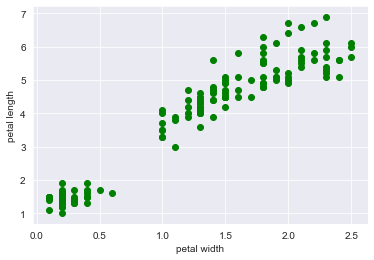

In [75]:
viz(df)


In [13]:
#Train Test split function

In [54]:
def train_test_split(df, test_size):
    if isinstance(test_size, float):
        test_size = round(test_size*len(df))
        
    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k = test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df

In [55]:
random.seed(0)
train, test = train_test_split(df, test_size = 20)

In [21]:
#Helper function

In [24]:
#Data Purity checak

In [36]:
def check_purity(data):
    unique_classes = np.unique(data[:, -1])
    if len(unique_classes) == 1:
        return True
    else:
        return False

In [39]:
#classify data

In [37]:
def classify_data(data):
    uniques_classes, count_uniques_classes = np.unique(data[:,-1], return_counts=True)
    max_count_idx = count_uniques_classes.argmax()
    classification = uniques_classes[max_count_idx]
    return classification

In [77]:
#potential split

In [38]:
def get_potential_splits(data):
    _, num_columns = data.shape
    potential_splits = {}
    for col_index in range(num_columns -1):
        potential_splits[col_index] = []
        values = data[:,col_index]
        unique_values = np.unique(values)
        for idx in range(len(unique_values)):
            if idx != 0:
                current_value = unique_values[idx]
                previous_value = unique_values[idx -1]
                potential_split = (current_value + previous_value) /2

                potential_splits[col_index].append(potential_split)

    return potential_splits

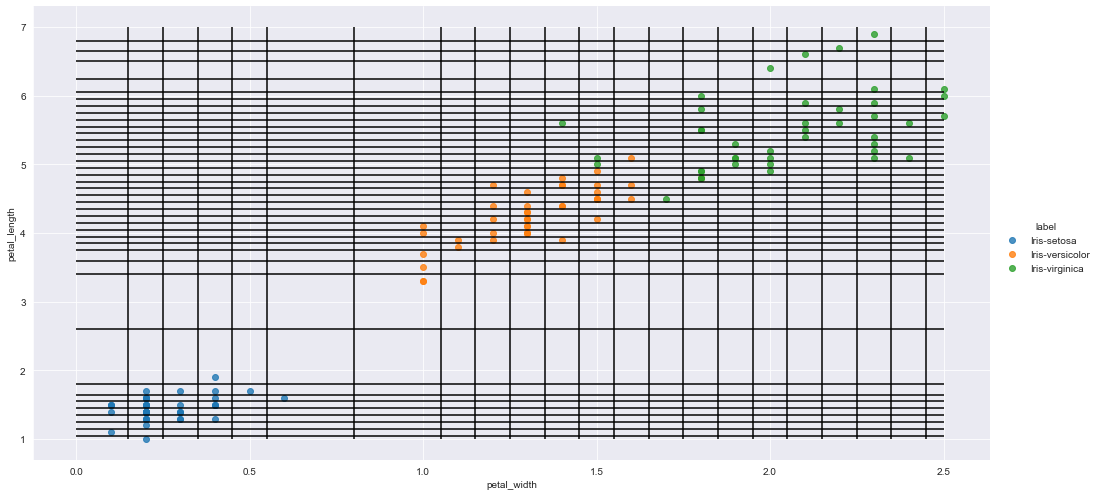

In [109]:
sns.lmplot(data=train, x='petal_width', y='petal_length', hue='label', fit_reg=False, size=7, aspect=2)

#plot lines wiht potential splits
plt.vlines(x=potential_splits[3], ymin=1, ymax=7)
plt.hlines(y = potential_splits[2], xmin = 0, xmax= 2.5)

In [110]:
#split data

In [39]:
def split_data(data, split_column, split_value):
    negative_data = data[data[:,3] <= split_value]
    positive_data = data[data[:,3] > split_value]
    return negative_data, positive_data

In [146]:
split_column = 3
split_value = 0.8

negative_data, positive_data = split_data(data, split_column, split_value)

(0, 2.6)

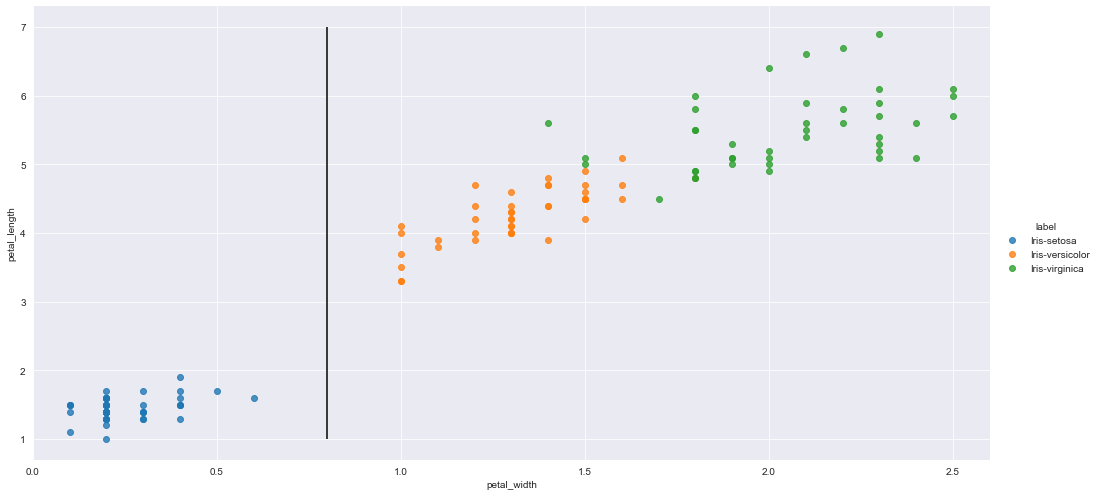

In [147]:
plotting_df = pd.DataFrame(data, columns=df.columns)
sns.lmplot(data=plotting_df, x='petal_width', y='petal_length', hue='label' ,fit_reg=False, size=7, aspect=2)
plt.vlines(x=split_value, ymin=1, ymax=7)
plt.xlim(0,2.6)

In [129]:
# lowest overall entropy

In [40]:
def calculate_entropy(data):
    _ , counts = np.unique( data[:, -1], return_counts=True)
    probablities = counts / counts.sum()
    entropy = sum(probablities * -np.log2(probablities))
    
    return entropy

In [41]:
def calculate_overall_entropy(negative_data, positive_data):
    data_points = len(negative_data) + len(positive_data)
    prob_negative_data = len(negative_data) / data_points
    prob_positive_data = len(positive_data) / data_points
    overall_entropy = (prob_negative_data * calculate_entropy(negative_data) + prob_positive_data * calculate_entropy(positive_data))
    
    return overall_entropy

In [42]:
def find_best_split(data, potential_splits):
    overall_entropy = 999
    for col_index in potential_splits:
        for value in potential_splits[col_index]:
            negative_data, positive_data = split_data(data, split_column=col_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(negative_data, positive_data)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy

                best_split_column = col_index
                best_split_value = value

    return best_split_column, best_split_value


In [157]:
potential_splits =  get_potential_splits(data)

In [162]:
find_best_split(data, potential_splits)

(3, 0.8)

In [163]:
### Decision Tree Algorithm

## subtree_pattern = {question:[yes_answer, no_answer]}
##example_tree = {"petal_width <= 0.8": ["Iris-setosa", 
#                                       {"petal_width < = 1.6": [{"petal_width <= 4.9": ["Iris-versicolor", "Iris-verginica"]},                                                                       "Iris-verginica"]} 
#                                       ]
#               }

In [164]:
### Algorithm

In [43]:
def decision_tree_algorithm(df, counter=0):
    #data prep
    if counter == 0:
        data = df.values
    else:
        data = df

    #base case
    if check_purity(data):
        classification = classify_data(data)
        return classification
    #recursive 
    else:
        counter += 1
        #helper functions
        potential_splits = get_potential_splits(data)
        split_column, split_value = find_best_split(data, potential_splits)
        negative_data, positive_data = split_data(data, split_column, split_value)

        #instantiate sub-tree
        question = "{} <= {}".format(split_column, split_value)
        sub_tree = {question:[]}

        #find answers
        #recursion

        ##here need not to be confused, negative means 0 or below the line and positive means 1 or above the line 
        ##../.. left -ve right +ve and this is multi class classification
        yes_answer = decision_tree_algorithm(negative_data, counter) 
        no_answer = decision_tree_algorithm(positive_data, counter)

        ##construct tree
        sub_tree[question].append(yes_answer)
        sub_tree[question].append(no_answer)

        return sub_tree

In [56]:
tree = decision_tree_algorithm(train)

In [57]:
pprint(tree)

{'3 <= 1.65': [{'3 <= 0.8': ['Iris-setosa', 'Iris-versicolor']},
               'Iris-virginica']}
